# TP 3 - MLAI - Adam ISMAILI

In [87]:
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torchvision.datasets.folder import ImageFolder
from torch.utils.data import DataLoader, Subset, ConcatDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [65]:
!pip install easyfsl

  Obtaining dependency information for easyfsl from https://files.pythonhosted.org/packages/e1/47/fa188980a02084661080fc07ac75150c45537308e769803fcf18653165fa/easyfsl-1.5.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 2.0 MB/s eta 0:00:00


In [66]:
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

## Exercice 0 - Création et entrainement du modèle MyNetork (tinyNet40)

Le modèle créé au TP 2 témoignant de pauvres performances, les données ont été rééxtraites, et le modèle a été refait et réentrainé.

In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        return self.dataset[idx]

    def __len__(self):
        return len(self.dataset)

In [3]:
transform = transforms.Compose([transforms.Resize((64, 64)), 
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = datasets.ImageFolder('/kaggle/input/tiny-imagenet/tiny-imagenet-200/train', transform=transform)

class_indices = [dataset.class_to_idx[class_name] for class_name in dataset.classes[:40]]

dataset_40 = [img for img in dataset if img[1] in class_indices]

dataset_40 = CustomDataset(dataset_40)

dataset_40

In [4]:
train_size = int(0.7 * len(dataset_40))
val_size = int(0.2 * len(dataset_40))
test_size = len(dataset_40) - (train_size + val_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_40, [train_size, val_size, test_size])

train_dataset, val_dataset, test_dataset

(<torch.utils.data.dataset.Subset at 0x7b7a2abf1630>,
 <torch.utils.data.dataset.Subset at 0x7b7a2abf3a90>)

In [5]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)

train_loader, val_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7b7ad85ee470>,
 <torch.utils.data.dataloader.DataLoader at 0x7b7ad85ed750>)

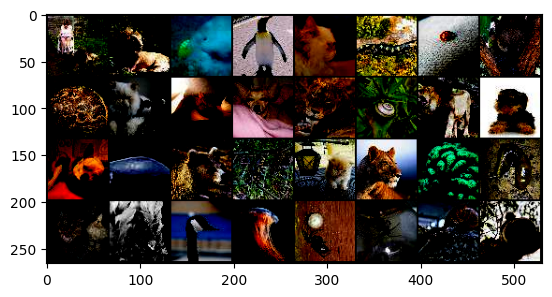

n03992509 n07715103 n04149813 n04265275 n07875152 n03976657 n09428293 n03854065 n04398044 n07875152 n04465501 n02917067 n07715103 n04398044 n07715103 n01950731 n02917067 n04149813 n04501370 n03976657 n07875152 n07715103 n02056570 n04540053 n07875152 n03770439 n09332890 n04399382 n04532106 n04532106 n04398044 n03854065


In [6]:
classes = tuple(os.listdir("/kaggle/input/tiny-imagenet/tiny-imagenet-200/train")[:40])

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
device = torch.device('cpu')

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Using GPU: {torch.cuda.get_device_name(0)}')

Using GPU: Tesla T4


In [49]:
num_classes = 40
    
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(256, 1024, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(1024)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        self.fc1 = nn.Linear(1024, 2048)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(2048, num_classes)

        # Weight initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.maxpool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.maxpool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.maxpool4(self.relu4(self.bn4(self.conv4(x))))

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)

        x = self.relu5(self.fc1(x))
        x = self.dropout5(x)
        x = self.fc2(x)

        return x

In [50]:
model = MyNetwork()

model

MyNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
epochs = 200

In [52]:
model.to(device)
best_model_wts = model.state_dict()
best_loss = float('inf')
best_acc = 0.0
 
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    total_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

    acc = correct / len(val_dataset) * 100
    
    print(f'Epoch {epoch+1} \t\t Validation Accuraccy: {acc} \t\t Validation Loss: {total_loss / len(val_loader)}')

    if total_loss < best_loss:
        best_loss = total_loss
        best_model_wts = model.state_dict()
        print("Loss decreased, model saved")
    if acc > best_acc:
        best_acc = acc
        best_model_wts = model.state_dict()
        print("Accuracy increased, model saved")

    scheduler.step(total_loss)

    torch.save(best_model_wts, 'best_model.pth')

print("finished")

Epoch 1 		 Validation Accuraccy: 6.550000000000001 		 Validation Loss: 3.57115931892395
Loss decreased, model saved
Accuracy increased, model saved
Epoch 2 		 Validation Accuraccy: 10.9 		 Validation Loss: 3.4248179035186768
Loss decreased, model saved
Accuracy increased, model saved
Epoch 3 		 Validation Accuraccy: 12.225 		 Validation Loss: 3.334516487121582
Loss decreased, model saved
Accuracy increased, model saved
Epoch 4 		 Validation Accuraccy: 11.700000000000001 		 Validation Loss: 3.329744140625
Loss decreased, model saved
Epoch 5 		 Validation Accuraccy: 12.675 		 Validation Loss: 3.269410104751587
Loss decreased, model saved
Accuracy increased, model saved
Epoch 6 		 Validation Accuraccy: 15.525 		 Validation Loss: 3.150038656234741
Loss decreased, model saved
Accuracy increased, model saved
Epoch 7 		 Validation Accuraccy: 17.1 		 Validation Loss: 3.081936731338501
Loss decreased, model saved
Accuracy increased, model saved
Epoch 8 		 Validation Accuraccy: 18.3 		 Validatio

Test Loss: 1.7595
Test Accuracy: 50.50%
Confusion Matrix:


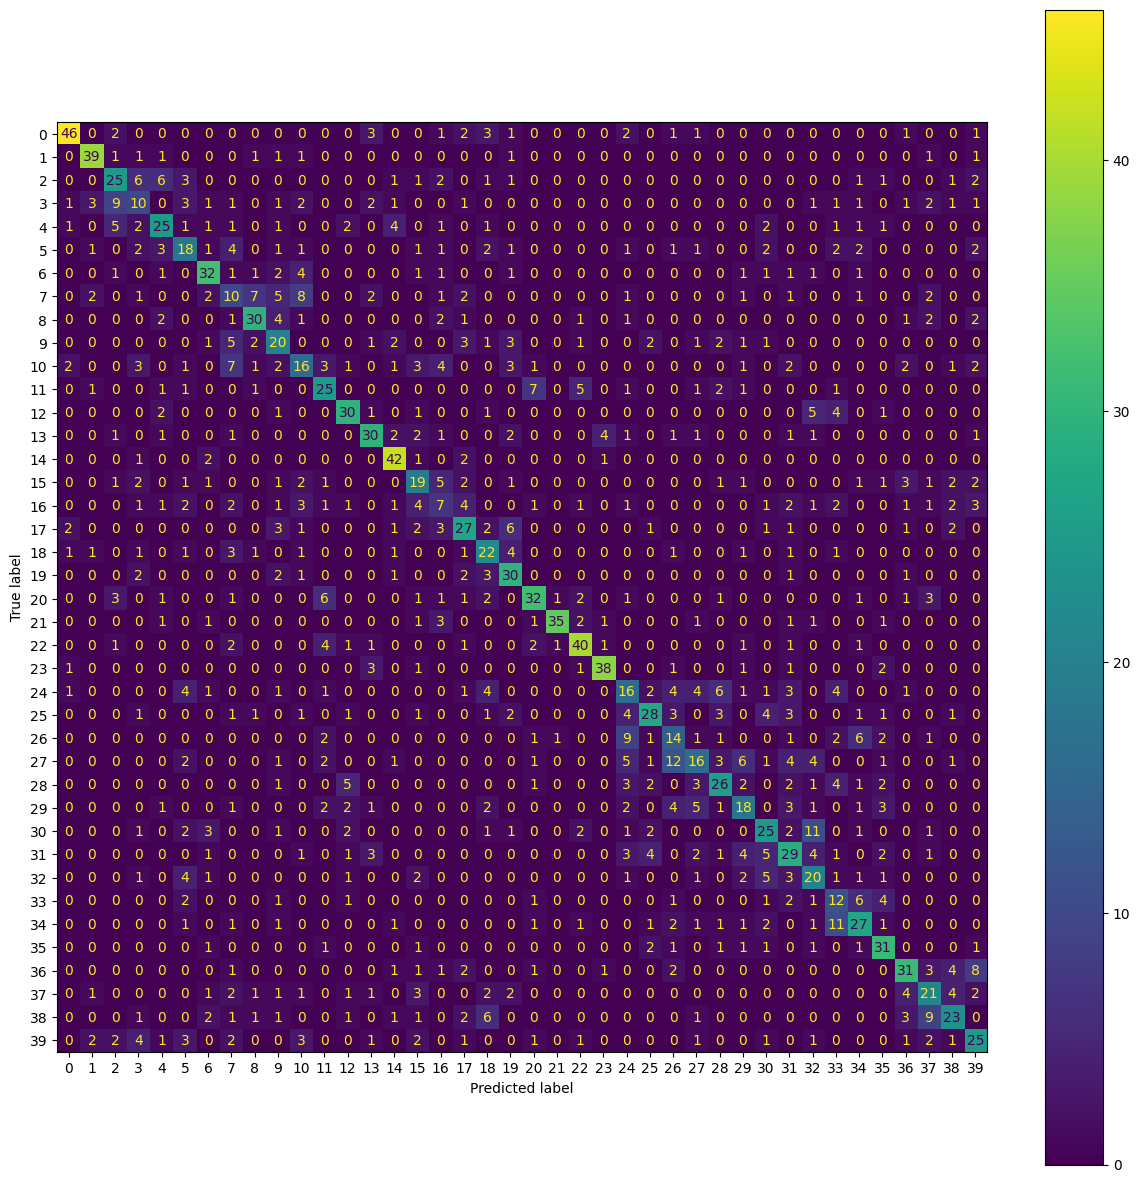

In [85]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

test_loss = test_loss / len(test_loader)

test_accuracy = 100 * correct / total

fig, ax = plt.subplots(figsize=(15, 15))
cm = confusion_matrix(all_targets, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(40)])

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print("Confusion Matrix:")
disp.plot(ax=ax)
plt.show()

On observe ici que le modèle dépasse légèrement la probablité d'1/2 en termes de précision globale, montrant que celui-ci vaut autant voire plus que la probabilité de deviner la classe d'un échantillon aléatoirement.

Ce modèle étant plus significatif que celui du TP 2, il peut donc être utilisé pour la suite du TP 3.

## Exercice 1 - Préparation du "support" et du "query" set

In [62]:
class_indices_2 = [dataset.class_to_idx[class_name] for class_name in dataset.classes[40:43]]

dataset_3 = [img for img in dataset if img[1] in class_indices_2]

dataset_3 = CustomDataset(dataset_3)

dataset_3

In [63]:
new_train_size = int(0.7 * len(dataset_3))
new_val_size = int(0.2 * len(dataset_3))
new_test_size = len(dataset_3) - (new_train_size + new_val_size)

new_train_dataset, new_val_dataset, new_test_dataset = torch.utils.data.random_split(dataset_3, [new_train_size, new_val_size, new_test_size])

new_train_dataset, new_val_dataset, new_test_dataset

(<torch.utils.data.dataset.Subset at 0x7b79d1999ae0>,
 <torch.utils.data.dataset.Subset at 0x7b79d17f5390>)

In [69]:
N_WAY = 3  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 7  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
new_test_dataset.get_labels = lambda: [
    instance[1] for instance in new_test_dataset
]
test_sampler = TaskSampler(
    new_test_dataset, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

new_test_loader = DataLoader(
    new_test_dataset,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

new_test_loader

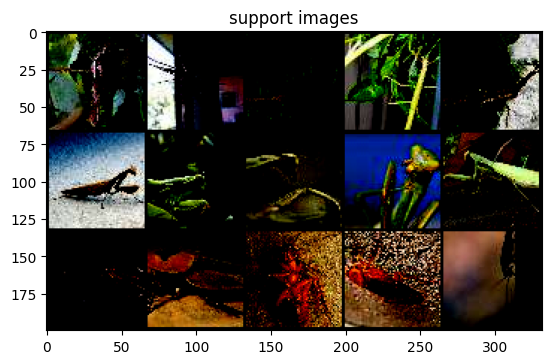

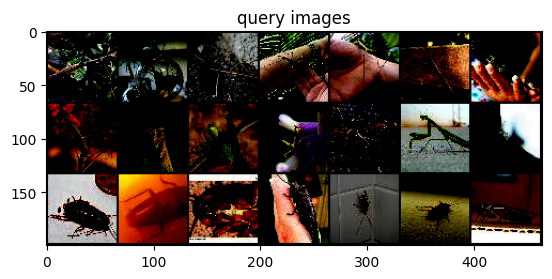

In [70]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(new_test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

## Exercice 2 - Adaptation de la classe PrototypicalNetwork et usage de la classe MyNetwork (tinyNet40) comme fonction de distance

In [75]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = MyNetwork()
convolutional_network.load_state_dict(model.state_dict())
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

new_model = PrototypicalNetworks(convolutional_network).cuda()

new_model

MyNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

PrototypicalNetworks(
  (backbone): MyNetwork(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn4): BatchNorm2d(1

In [84]:
new_model.eval()
example_scores = new_model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

score = 0

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)) :
    if (example_query_labels[i] == example_predicted_labels[i]) :
        score += 1
    print(f"{example_query_labels[i]} / {example_predicted_labels[i]}")

score = score / len(example_query_labels) * 100

print("score : ", np.round(score), "%")

Ground Truth / Predicted
0 / 0
0 / 0
0 / 0
0 / 2
0 / 1
0 / 0
0 / 1
2 / 1
2 / 0
2 / 0
2 / 2
2 / 1
2 / 2
2 / 1
1 / 1
1 / 1
1 / 0
1 / 0
1 / 2
1 / 2
1 / 0
score :  38.0 %


Le score n'est pas élevé, mais reste cohérent avec notre modèle sur un petit échantillon, ayant une chance proche de 1/2 de trouver la bonne classe d'une image.

In [88]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            new_model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    new_model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(new_test_loader)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 100/100 [00:01<00:00, 85.52it/s]

Model tested on 100 tasks. Accuracy: 42.95%


La précision de note modèle est de 42.95%. Elle n'est pas grande, et inférieure à la précision de trouver la bonne classe d'une image aléatoirement. Cependant, elle reste proche de la probabilité de notre modèle de trouver la bonne classe d'une image (50%) sans entrainement préalable sur les 3 nouvelles classes étudiées, montrant l'intérêt du few-shot classification.